In [2]:
import torch
from models.glom import GLOM
import matplotlib.pyplot as plt
import yaml
from einops import repeat
import numpy as np
import random
from torch.nn.functional import mse_loss
import wandb
import os
from einops.layers.torch import Rearrange

np.set_printoptions(suppress=True)

In [15]:
test = torch.arange(10).reshape((2,5)).float()
test

tensor([[0., 1., 2., 3., 4.],
        [5., 6., 7., 8., 9.]])

In [23]:
test.softmax(-1).shape

torch.Size([2, 5])

# Useful function

In [10]:
# Prints a grid of images, with or without patch grids
def show_image_grid(*image_rows, grid=False):
    images_rows = [np.array(row) for row in image_rows]
    n = len(images_rows)
    m = len(images_rows[0])
    fig, axes = plt.subplots(n,m)
    for i in range(n):
        for j in range(m):
            im = axes[i,j].imshow(images_rows[i][j].squeeze())
            if grid:
                axes[i,j].set_xticks(np.arange(0,28,4))
                axes[i,j].set_yticks(np.arange(0,28,4))
                axes[i,j].grid(color='white', linestyle='-', lw=2)
                for tick in axes[i,j].xaxis.get_major_ticks():
                    tick.tick1line.set_visible(False)
                    tick.tick2line.set_visible(False)
                    tick.label1.set_visible(False)
                    tick.label2.set_visible(False)
                for tick in axes[i,j].yaxis.get_major_ticks():
                    tick.tick1line.set_visible(False)
                    tick.tick2line.set_visible(False)
                    tick.label1.set_visible(False)
                    tick.label2.set_visible(False)
            else:
                axes[i,j].axis('off')
            
    plt.subplots_adjust(wspace=1, hspace=1)
    plt.tight_layout()

# Turns a batch of images into patches
patchify = torch.nn.Sequential(
    torch.nn.Unfold(kernel_size=(4,4), stride=(4,4)),
    Rearrange('b (h w) (H W) -> b H W h w', h=4, w=4, H=7, W=7)
    )

# Open W&B sesion

In [3]:
run = wandb.init()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: leogagnon. Use `wandb login --relogin` to force relogin


# Load the dataset

In [4]:
from datamodules import MNISTDataset
from utils import RandomPatchMask
from custom_transforms import GaussianNoise

# Get dataloader, generate a batch
dm = MNISTDataset(data_dir=os.environ['SCRATCH']+'/datasets', batch_size=32)
dm.setup(stage='test')
dataloader = dm.test_dataloader()
clean = next(iter(dataloader))[0]

gaussian_noise = GaussianNoise(mean=0., std=0.01)
patch_masker = RandomPatchMask(patch_size=4, p=0.3)

corrupt, patch_mask = patch_masker(gaussian_noise(clean))

# Load saved models

In [7]:
models = {
    'local': 'leogagnon/GLOM/model-bh6l2pzb:v0',
    'nonLocal_noPatch': 'leogagnon/GLOM/model-1q47n3zr:v0',
    'nonLocal_patch': 'leogagnon/GLOM/model-2mygieci:v0'
}

for key in models.keys():
    path = run.use_artifact(models[key], type='model').download()
    models.update({key: GLOM.load_from_checkpoint(os.path.join(path,'model.ckpt'))})

/home/mila/l/leo.gagnon/columns/venv/lib/python3.7/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [31]:
models.update({'init': GLOM(**models['local'].hparams)})

# Run a model

In [32]:
# Choose which model to use
glom = models['init'];
glom.eval();
glom.hparams

"add_embedding":      False
"attention_radius":   0
"cell_dim":           59
"contributions":      1
"decoder":            patch
"encoder":            patch
"image_side":         28
"in_channels":        1
"local_loss":         True
"location_embedding": True
"n_iter":             8
"n_level":            3
"noise_std":          0.03538755944746402
"patch_mask_prob":    0.2
"patch_side":         4
"reg_coeff":          0.7569555183890435
"softmax_T":          0.3658341397811361
"td_activation":      siren

In [36]:
# Run the batch of data through the model, compute loss
with torch.no_grad():
    embedding = glom.encoder(corrupt)

    state_traj = []
    recon_traj = []

    state = repeat(glom.init_column(), 'l d -> b n l d', b=embedding.shape[0], n=embedding.shape[1])
    state_traj += [state]
    recon_traj += [corrupt]

    # Infer loop
    for _ in range(20):
        state, latent_recon, (bu, td, lat) = glom.forward(embedding, state, mask=patch_mask)
        state_traj += [state]
        recon_traj += [glom.decoder(latent_recon)]
    
    state_traj = torch.stack(state_traj)
    recon_traj = torch.stack(recon_traj)

    recon = recon_traj[-1]

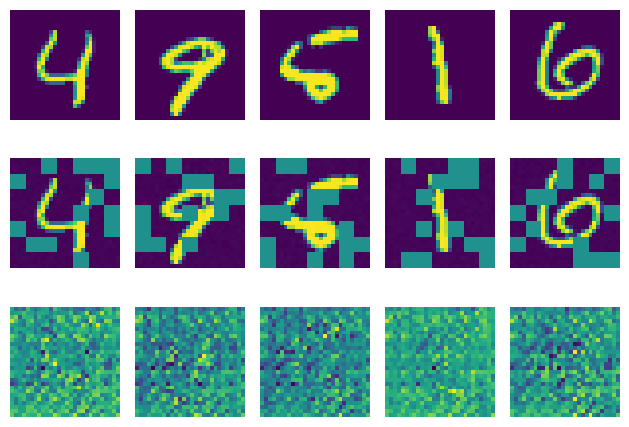

In [34]:
# Print random samples
idx = random.sample(list(np.arange(len(clean))), 5)
show_image_grid(clean[idx], corrupt[idx], recon[idx], grid=False)

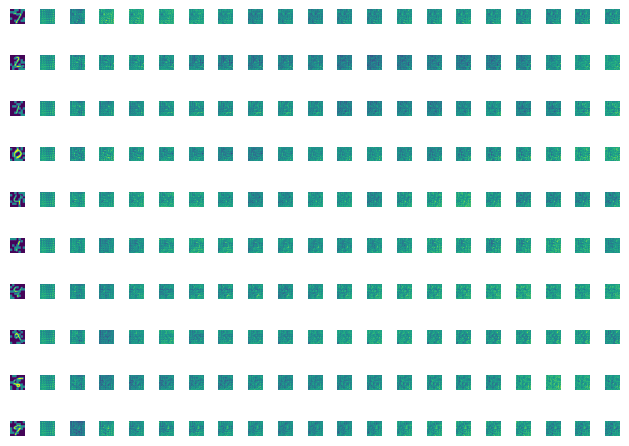

In [38]:
# Print reconstruction trajectory
show_image_grid(*[recon_traj[:,i] for i in range(10)])

# Latent cell inspection

## Clustering

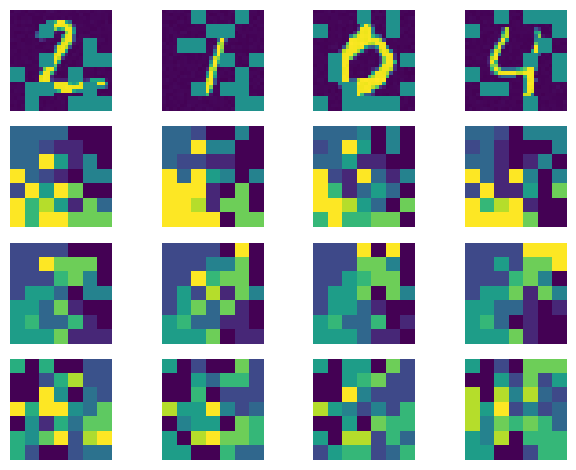

In [17]:
from sklearn.cluster import AgglomerativeClustering, KMeans, Birch

clustering = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='ward')
#clustering = KMeans(n_clusters=3)
#clustering = Birch(threshold=0.005, n_clusters=2)

labels = []

for i in range(glom.n_level): 
    samples = state.flatten(start_dim=0, end_dim=1)[:,i]
    clusters = clustering.fit(samples)
    labels.append(clusters.labels_)

show_image_grid(corrupt[1:5], *[labels[i].reshape((32,7,7))[1:5] for i in range(glom.n_level)])

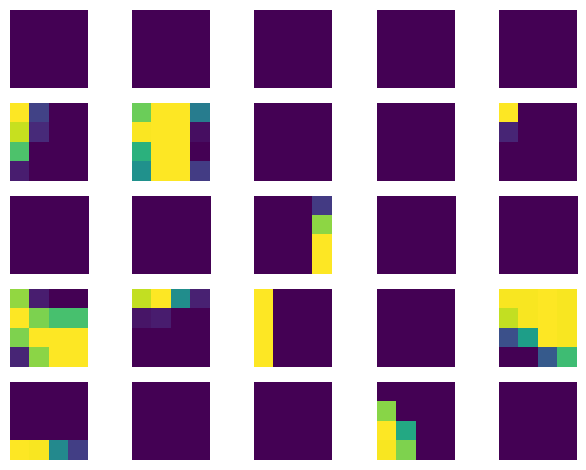

In [23]:
patches = patchify(clean)
patches_label = [patches[(labels[1]==i).reshape((32,7,7))] for i in range(10)]

show_image_grid(*[patches_label[i][torch.randperm(len(patches_label[i]))[:5]] for i in range(5)])

## PCA projection

[0.44758809 0.26104008]
[0.45504666 0.18105947]
[0.67647017 0.11638444]


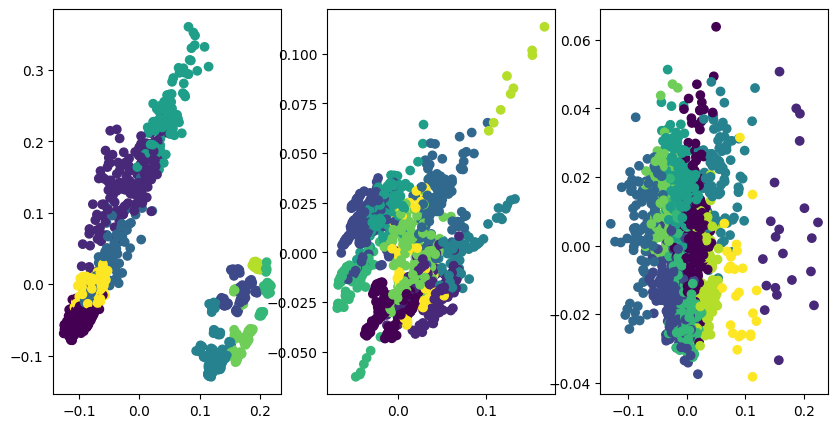

In [26]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pc_layer = []

for i in range(glom.n_level): 
    samples = state.flatten(start_dim=0, end_dim=1)[:,i]
    pc = pca.fit(samples)
    print(pc.explained_variance_ratio_)
    pc_layer.append(pc.transform(samples))

fig, axes = plt.subplots(1,glom.n_level, figsize=(10,5))

for i in range(glom.n_level):
    axes[i].scatter(pc_layer[i][:,0],pc_layer[i][:,1],c=labels[i])

/home/mila/l/leo.gagnon/columns/venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/home/mila/l/leo.gagnon/columns/venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/home/mila/l/leo.gagnon/columns/venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


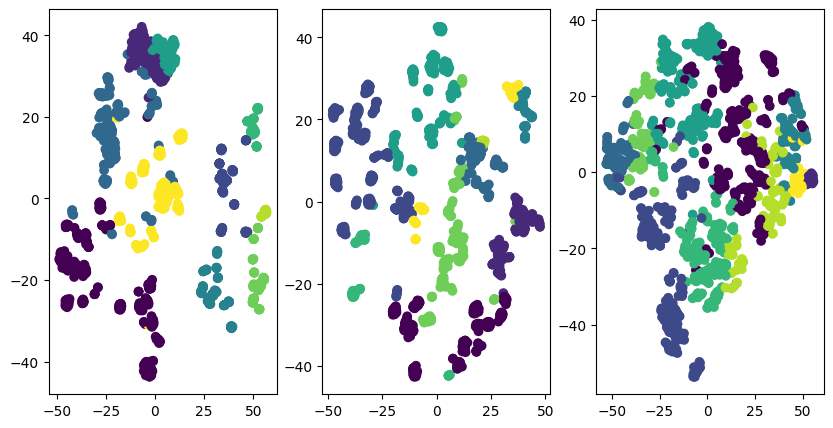

In [25]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init='pca', learning_rate='auto')
tsne_layer = []

for i in range(glom.n_level): 
    samples = state.flatten(start_dim=0, end_dim=1)[:,i]
    tsne_layer.append(tsne.fit_transform(samples))

fig, axes = plt.subplots(1,glom.n_level, figsize=(10,5))

for i in range(glom.n_level):
    axes[i].scatter(tsne_layer[i][:,0],tsne_layer[i][:,1],c=labels[i])
